In [2]:
from fast_to_SQL.fast_to_SQL import to_sql_fast
import pandas as pd
import numpy as np
from urllib.parse import quote_plus
import sqlalchemy

params = quote_plus(
    """DRIVER={ODBC Driver 13 for SQL Server};
    SERVER=server-dw01.database.windows.net;
    DATABASE=DataWarehouseStaging;
    UID=dw_userlogin;
    PWD=kljDueK!7"""
)

ENGINE = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [3]:
df = pd.read_sql('''SELECT d.[factorRate]
	,d.[monthsToPayback]
	,d.[split]
	,d.amountRequested / d.[averageMonthlyVolume] AS [multiple]
	,c.[Written Off]

FROM [dbo].[Prices] AS p

LEFT JOIN PriceDetails AS d
	ON p._id = d._id

LEFT JOIN Applications AS a
	ON a.[applicationKey] = p.[applicationId]

LEFT JOIN Opportunities AS o
	ON o.[application ID] = a.[applicationKey]

LEFT JOIN Contracts AS c
	ON o.[Opportunity ID] = c.[Original Opportunity ID]

WHERE CASE 
		WHEN PriceDetail_idx = (
				SELECT MAX(PriceDetail_idx)
				
				FROM PriceDetails AS exc
				
				WHERE exc._id = d._id
				)
			THEN 1
		ELSE 0
		END = 1
	AND (
		c.[Contract End Date] IS NOT NULL
		OR c.[Written Off] = 1
		)

''', ENGINE)

ProgrammingError: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 13 for SQL Server][SQL Server]Error retrieving data from server-dw01.database.windows.net.DataWarehouse.  The underlying error message received was: 'Divide by zero error encountered.'. (46823) (SQLExecDirectW)")
[SQL: SELECT d.[factorRate]
	,d.[monthsToPayback]
	,d.[split]
	,d.amountRequested / d.[averageMonthlyVolume] AS [multiple]
	,c.[Written Off]

FROM [dbo].[Prices] AS p

LEFT JOIN PriceDetails AS d
	ON p._id = d._id

LEFT JOIN Applications AS a
	ON a.[applicationKey] = p.[applicationId]

LEFT JOIN Opportunities AS o
	ON o.[application ID] = a.[applicationKey]

LEFT JOIN Contracts AS c
	ON o.[Opportunity ID] = c.[Original Opportunity ID]

WHERE CASE 
		WHEN PriceDetail_idx = (
				SELECT MAX(PriceDetail_idx)
				
				FROM PriceDetails AS exc
				
				WHERE exc._id = d._id
				)
			THEN 1
		ELSE 0
		END = 1
	AND (
		c.[Contract End Date] IS NOT NULL
		OR c.[Written Off] = 1
		)

]
(Background on this error at: http://sqlalche.me/e/f405)

In [ ]:
df[['factorRate', 'monthsToPayback', 'split', 'multiple']] = df[['factorRate', 'monthsToPayback', 'split', 'multiple']].astype('float64')

In [ ]:
df.groupby(pd.qcut(df['multiple'], 5, labels = False, duplicates = 'drop'))['Written Off'].mean().plot()

In [139]:
feature_list = ['monthsToPayback', 'split', 'multiple']

In [141]:
#remove outcome from features
y = df['Written Off']
X = df[feature_list]

In [142]:
feature_list

['monthsToPayback', 'split', 'multiple']

In [143]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X, y), columns = X.columns)

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [145]:
weight = 1/y_train.mean()
weight

7.300632911392406

In [146]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.2,
                max_depth = 5, alpha = 10, n_estimators = 50, scale_pos_weight = weight, n_jobs = -1)

In [147]:
xgbc.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.300632911392406,
              seed=None, silent=None, subsample=1, verbosity=1)

In [148]:
preds = xgbc.predict_proba(X_test)[:,1]

In [149]:
from sklearn.metrics import roc_auc_score
def gini(roc_auc_score):
    return roc_auc_score*2-1

roc_auc = roc_auc_score(y_test, preds)
print(f'ROC AUC Score = {roc_auc}')
print(f'Gini = {gini(roc_auc)}')

ROC AUC Score = 0.532848169807234
Gini = 0.06569633961446808


In [150]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
rdm_params = {
        'min_child_weight': [5, 10, 20, 30, 40],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5],
        'n_estimators': [20, 30, 50]
        }

In [151]:
rdm_search = RandomizedSearchCV(xgbc, param_distributions = rdm_params, n_iter = 200,
                                scoring = 'roc_auc', n_jobs = -1, cv = 5, verbose = 10, random_state = 42)

In [152]:
rdm_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1933s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 260 tas

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(alpha=10, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.3, gamma=0,
                                           learning_rate=0.2, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=50,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0,...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=200,

In [153]:
rdm_search.best_params_

{'subsample': 0.8,
 'n_estimators': 30,
 'min_child_weight': 30,
 'max_depth': 3,
 'gamma': 0.5,
 'colsample_bytree': 1.0}

In [154]:
xgbc_rdm = rdm_search.best_estimator_
xgbc_rdm.fit(X_train, y_train)
rdm_preds = xgbc_rdm.predict_proba(X_test)[:,1]

In [155]:
rdm_roc_auc = roc_auc_score(y_test, rdm_preds)
print(f'ROC AUC Score = {rdm_roc_auc}')
print(f'Gini = {gini(rdm_roc_auc)}')

ROC AUC Score = 0.5499198613818497
Gini = 0.09983972276369935


In [165]:
test_df = pd.DataFrame(y_test).merge(df[feature_list], how = 'left', left_index = True, right_index = True)
test_df['pred'] = rdm_preds

In [166]:
test_df['pred_pentile'] = pd.qcut(test_df['pred'], 5, labels = False, duplicates = 'drop')

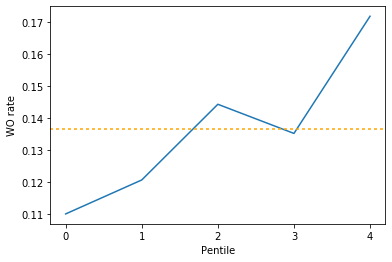

In [170]:
import matplotlib.pyplot as plt
plt.plot(test_df.groupby('pred_pentile')['Written Off'].mean())
plt.axhline(test_df['Written Off'].mean(), color = 'orange', dashes = [2, 2])
plt.xticks(np.arange(0,5))
plt.xlabel('Pentile')
plt.ylabel('WO rate')
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
#plt.text(x = 1.5, y = 0.2, s= 'Gini = 0.24', fontdict = font)

In [168]:
test_df.groupby('pred_pentile')['multiple'].mean()

pred_pentile
0    1.736914
1    1.095742
2    0.993969
3    0.961264
4    0.943257
Name: multiple, dtype: float64

In [169]:
test_df.dtypes

Written Off          int64
monthsToPayback    float64
split              float64
multiple           float64
pred               float32
pred_pentile         int64
dtype: object

In [164]:
X_train

,monthsToPayback,split,multiple
2286,0.285507,-1.675247,0.724653
2698,0.643003,0.475567,-0.645316
1229,1.367281,-1.460166,-0.162524
2073,0.271578,0.475567,-0.571316
1266,-1.455547,0.260485,0.498154
...,...,...,...
683,1.747992,0.475567,-0.744411
213,1.283711,-1.675247,0.039664
553,-0.573413,0.690648,-0.165237
2598,0.002295,-1.675247,0.803160
